Iniciando a comparação de validação cruzada...

--- Executando com KFold-10 (Baseline) ---
Melhores hiperparâmetros (KFold): {'svm__C': 100, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
Acurácia média (KFold): 76.56%
Desvio Padrão (KFold): 0.05

--- Executando com RepeatedStratifiedKFold (10x3) ---
Melhores hiperparâmetros (RepeatedStratifiedKFold): {'svm__C': 0.01, 'svm__kernel': 'linear'}
Acurácia média (RepeatedStratifiedKFold): 76.82%
Desvio Padrão (RepeatedStratifiedKFold): 0.04


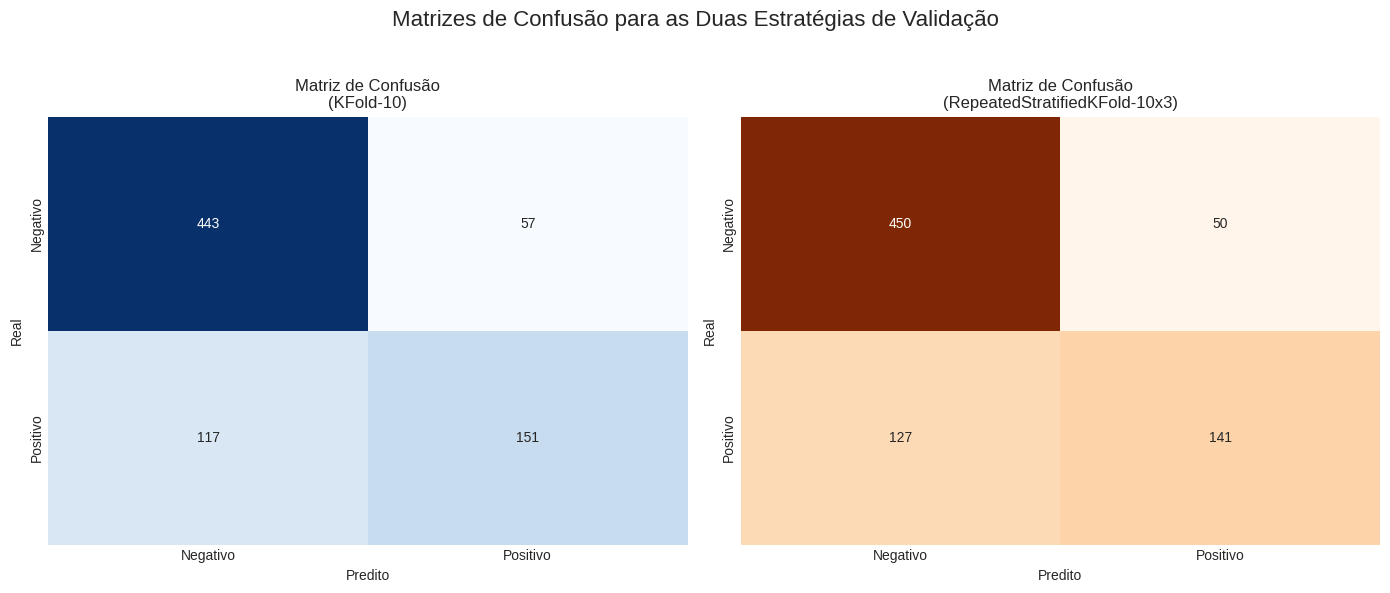


--- Interpretação dos Resultados ---

Resumo da Matriz de Confusão (KFold-10):
Verdadeiros Negativos (TN): 443
Falsos Positivos (FP): 57 (Erros do tipo I - predito como positivo, mas é negativo)
Falsos Negativos (FN): 117 (Erros do tipo II - predito como negativo, mas é positivo)
Verdadeiros Positivos (TP): 151

Resumo da Matriz de Confusão (RepeatedStratifiedKFold-10x3):
Verdadeiros Negativos (TN): 450
Falsos Positivos (FP): 50
Falsos Negativos (FN): 127
Verdadeiros Positivos (TP): 141

--- Conclusão da Comparação ---
Analisando as acurácias médias e os desvios padrão, você pode ver se uma estratégia de validação fornece um resultado mais estável e confiável.
O KFold padrão é mais rápido, mas pode ter resultados menos robustos, enquanto o RepeatedStratifiedKFold, por repetir o processo, oferece uma estimativa mais confiável da performance do modelo.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

try:
    df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv',
                     header=None)
    df.columns = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness',
                  'insulin', 'bmi', 'diabetes_pedigree', 'age', 'outcome']
except Exception as e:
    print(f"Erro ao carregar o dataset: {e}")
    exit()


X = df.drop('outcome', axis=1)
y = df['outcome']


cols_to_impute = ['glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi']
X[cols_to_impute] = X[cols_to_impute].replace(0, np.nan)


pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('svm', SVC())
])
param_grid = [
    {
        'svm__kernel': ['linear'],
        'svm__C': [0.01, 0.1, 1, 10, 100]
    },
    {
        'svm__kernel': ['rbf'],
        'svm__C': [0.01, 0.1, 1, 10, 100],
        'svm__gamma': ['scale', 0.01, 0.001]
    }
]
print("Iniciando a comparação de validação cruzada...")


print("\n--- Executando com KFold-10 (Baseline) ---")
cv_kfold = KFold(n_splits=10, shuffle=True, random_state=42)
grid_kfold = GridSearchCV(pipeline, param_grid, cv=cv_kfold, scoring='accuracy', n_jobs=-1)
grid_kfold.fit(X, y)

print("Melhores hiperparâmetros (KFold):", grid_kfold.best_params_)
print("Acurácia média (KFold): {:.2f}%".format(grid_kfold.best_score_ * 100))
print("Desvio Padrão (KFold): {:.2f}".format(grid_kfold.cv_results_['std_test_score'][grid_kfold.best_index_]))

print("\n--- Executando com RepeatedStratifiedKFold (10x3) ---")
cv_rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
grid_rskf = GridSearchCV(pipeline, param_grid, cv=cv_rskf, scoring='accuracy', n_jobs=-1)
grid_rskf.fit(X, y)

print("Melhores hiperparâmetros (RepeatedStratifiedKFold):", grid_rskf.best_params_)
print("Acurácia média (RepeatedStratifiedKFold): {:.2f}%".format(grid_rskf.best_score_ * 100))
print("Desvio Padrão (RepeatedStratifiedKFold): {:.2f}".format(grid_rskf.cv_results_['std_test_score'][grid_rskf.best_index_]))

best_model_kfold = grid_kfold.best_estimator_
y_pred_kfold = best_model_kfold.predict(X)
cm_kfold = confusion_matrix(y, y_pred_kfold)


best_model_rskf = grid_rskf.best_estimator_
y_pred_rskf = best_model_rskf.predict(X)
cm_rskf = confusion_matrix(y, y_pred_rskf)


plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_kfold, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False)
ax1.set_title(f'Matriz de Confusão\n(KFold-10)')
ax1.set_xlabel('Predito')
ax1.set_ylabel('Real')
ax1.set_xticklabels(['Negativo', 'Positivo'])
ax1.set_yticklabels(['Negativo', 'Positivo'])

sns.heatmap(cm_rskf, annot=True, fmt='d', cmap='Oranges', ax=ax2, cbar=False)
ax2.set_title(f'Matriz de Confusão\n(RepeatedStratifiedKFold-10x3)')
ax2.set_xlabel('Predito')
ax2.set_ylabel('Real')
ax2.set_xticklabels(['Negativo', 'Positivo'])
ax2.set_yticklabels(['Negativo', 'Positivo'])

fig.suptitle('Matrizes de Confusão para as Duas Estratégias de Validação', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("\n--- Interpretação dos Resultados ---")
print("\nResumo da Matriz de Confusão (KFold-10):")
print(f"Verdadeiros Negativos (TN): {cm_kfold[0, 0]}")
print(f"Falsos Positivos (FP): {cm_kfold[0, 1]} (Erros do tipo I - predito como positivo, mas é negativo)")
print(f"Falsos Negativos (FN): {cm_kfold[1, 0]} (Erros do tipo II - predito como negativo, mas é positivo)")
print(f"Verdadeiros Positivos (TP): {cm_kfold[1, 1]}")

print("\nResumo da Matriz de Confusão (RepeatedStratifiedKFold-10x3):")
print(f"Verdadeiros Negativos (TN): {cm_rskf[0, 0]}")
print(f"Falsos Positivos (FP): {cm_rskf[0, 1]}")
print(f"Falsos Negativos (FN): {cm_rskf[1, 0]}")
print(f"Verdadeiros Positivos (TP): {cm_rskf[1, 1]}")

print("\n--- Conclusão da Comparação ---")
print("Analisando as acurácias médias e os desvios padrão, você pode ver se uma estratégia de validação fornece um resultado mais estável e confiável.")
print("O KFold padrão é mais rápido, mas pode ter resultados menos robustos, enquanto o RepeatedStratifiedKFold, por repetir o processo, oferece uma estimativa mais confiável da performance do modelo.")